# Generating synthetic data

This script generates the synthetic dataset used and, through it, attempts to undertand (in practical terms) Pearl's structural counterfactuals (SCF) generation process (abduction - action - prediction) under *causal sufficiency*. 

In the context of situation testing (ST), given a structural causal model (SCM) *M*, for the factual tuple {$x^F$} we want to generate its structural counterfactual {$x^{SCF}$} by changing the protected attribute $A$ from $a^F=a$ to $a^{SCF}=a'$ and letting the effects propagate across *M*.

We use Figure 1 from [Karimi et al. (2020)](https://arxiv.org/pdf/2002.06278.pdf) as the data generating model (DGM).

In [1]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
# set working directory - note: all code runs from the src folder
wrk_dir = os.getcwd()
# set data path
data_path = wrk_dir + '\\' + 'data' + '\\'

### Version 1: Causal Sufficiency; without $A$
With the DAG: $X_1->Y$, $X_1->X_2$, and $X_2->Y$.

In [3]:
# overall params
np.random.seed(2022)
n = 5000

# (hyper)parameters
# p_rate = 10
# n_mu = 0.0
# n_sigma = 1.0
lambda_1 = 10000
lambda_2 = 2500
beta_1 = (3/10)
beta_2 = 5
#epsilon = 225000

u1 = lambda_1*np.random.poisson(lam=10, size=n)
u2 = lambda_2*np.random.normal(loc=0.0, scale=1.0, size=n)

# annual salary
x1 = u1
# account balance
x2 = beta_1*x1 + u2
# loan approval
y = np.sign(x1 + beta_2*x2 - 225000)

In [4]:
# make a dataset for the observables and unobservables
d = {'LoanApproval': y, 
     'AnnualSalary': x1, 
     'AccountBalance': x2,
     'u1': u1,
     'u2': u2}
data = pd.DataFrame(d)
data.head(10)

,LoanApproval,AnnualSalary,AccountBalance,u1,u2
0,-1.0,50000,14026.847358,50000,-973.152642
1,1.0,120000,36940.097383,120000,940.097383
2,-1.0,90000,23564.129008,90000,-3435.870992
3,-1.0,80000,27596.570524,80000,3596.570524
4,1.0,210000,62294.221620,210000,-705.778380
5,1.0,120000,32827.008724,120000,-3172.991276
6,-1.0,80000,19749.048087,80000,-4250.951913
7,1.0,140000,45716.973279,140000,3716.973279
8,-1.0,70000,22540.642141,70000,1540.642141
9,1.0,110000,30629.344885,110000,-2370.655115


In [5]:
# check for negative values
print(data.shape)
data = data[(data['AnnualSalary'] >= 0) & (data['AccountBalance'] >= 0)]
print(data.shape)

(5000, 5)
(5000, 5)


In [6]:
# store in data folder
data.to_csv(data_path + '\\' + 'Karimi2020_v1.csv', sep='|', index=False)

Can I say anything about the error terms' moments based on the 'observed' Us?

It seems that for the white noise, yes. Realistically, however, we assume to know $F$ and its moments - too restrictive for an additve noise model used for discrimination, no?

In [7]:
# recall u1 is a Poisson
print(round(np.mean(data['u1']), 1))
print(round(np.sqrt(np.var(data['u1'])), 1))

100244.0
32196.6


In [8]:
# recall u2 is a White Noise
print(round(np.mean(data['u2']), 1))
print(round(np.sqrt(np.var(data['u2'])), 1))

17.1
2516.0


### (1) Estimate $f_j$

My interpretation of the paper is that, under causal sufficiency, focus is on estimating $f_j$ from the $X_j = f_j(X_{pa(j)}) + U$. If we 'assume' $f_j$ to be linar, the OLS estimator (being BLUE) is the best option. In other words,

$ X_j = \beta_0 + \sum \beta \times X_{par(j)} + U_j$

In [9]:
model = LinearRegression(fit_intercept=True, normalize=False)

In [10]:
x = np.array(data['AnnualSalary'].copy()).reshape((-1, 1))
print(x.shape)
y = np.array(data['AccountBalance'].copy())
print(y.shape)

(5000, 1)
(5000,)


In [11]:
model.fit(x, y)

LinearRegression()

In [12]:
hat_beta1 = model.coef_[0]
hat_beta1

0.2991165342281786

In [13]:
hat_beta0 = model.intercept_
hat_beta0

105.62201565680152

In [14]:
scf_data = data[['AnnualSalary', 'AccountBalance', 'u1', 'u2']].copy()
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2
0,50000,14026.847358,50000,-973.152642
1,120000,36940.097383,120000,940.097383
2,90000,23564.129008,90000,-3435.870992
3,80000,27596.570524,80000,3596.570524
4,210000,62294.221620,210000,-705.778380


In [15]:
scf_data['hat_AccountBalance'] = model.predict(x)
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance
0,50000,14026.847358,50000,-973.152642,15061.448727
1,120000,36940.097383,120000,940.097383,35999.606123
2,90000,23564.129008,90000,-3435.870992,27026.110096
3,80000,27596.570524,80000,3596.570524,24034.944754
4,210000,62294.221620,210000,-705.778380,62920.094204


In [16]:
scf_data['diff_AccountBalance'] = round(scf_data['AccountBalance'] - scf_data['hat_AccountBalance'], 2)
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance,diff_AccountBalance
0,50000,14026.847358,50000,-973.152642,15061.448727,-1034.60
1,120000,36940.097383,120000,940.097383,35999.606123,940.49
2,90000,23564.129008,90000,-3435.870992,27026.110096,-3461.98
3,80000,27596.570524,80000,3596.570524,24034.944754,3561.63
4,210000,62294.221620,210000,-705.778380,62920.094204,-625.87


(array([  11.,   76.,  261.,  617., 1048., 1266.,  978.,  503.,  189.,
          51.]),
 array([-8613.13 , -7009.916, -5406.702, -3803.488, -2200.274,  -597.06 ,
         1006.154,  2609.368,  4212.582,  5815.796,  7419.01 ]),
 <BarContainer object of 10 artists>)

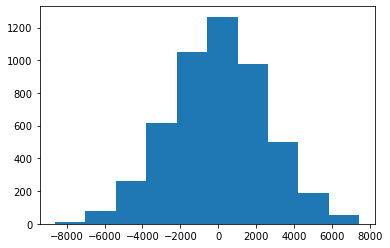

In [17]:
plt.hist(scf_data['diff_AccountBalance'])

In [18]:
scf_data['perc_diff_AccountBalance'] = round( np.sqrt( (scf_data['AccountBalance'] - scf_data['hat_AccountBalance'])**2 ) * 100 / scf_data['AccountBalance'], 2)
scf_data.head(10)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance,diff_AccountBalance,perc_diff_AccountBalance
0,50000,14026.847358,50000,-973.152642,15061.448727,-1034.60,7.38
1,120000,36940.097383,120000,940.097383,35999.606123,940.49,2.55
2,90000,23564.129008,90000,-3435.870992,27026.110096,-3461.98,14.69
3,80000,27596.570524,80000,3596.570524,24034.944754,3561.63,12.91
4,210000,62294.221620,210000,-705.778380,62920.094204,-625.87,1.00
5,120000,32827.008724,120000,-3172.991276,35999.606123,-3172.60,9.66
6,80000,19749.048087,80000,-4250.951913,24034.944754,-4285.90,21.70
7,140000,45716.973279,140000,3716.973279,41981.936808,3735.04,8.17
8,70000,22540.642141,70000,1540.642141,21043.779412,1496.86,6.64
9,110000,30629.344885,110000,-2370.655115,33008.440781,-2379.10,7.77


In [19]:
# can we start talking about a threshold here?
error_threshold = 5.0

scf_data[scf_data['perc_diff_AccountBalance'] <= error_threshold].shape

(2247, 7)

(array([  11.,   76.,  261.,  617., 1048., 1266.,  978.,  503.,  189.,
          51.]),
 array([-8613.13 , -7009.916, -5406.702, -3803.488, -2200.274,  -597.06 ,
         1006.154,  2609.368,  4212.582,  5815.796,  7419.01 ]),
 <BarContainer object of 10 artists>)

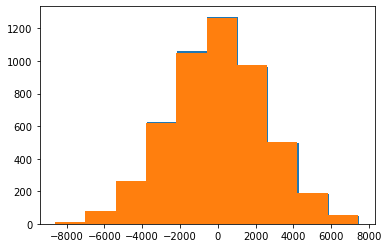

In [20]:
plt.hist(scf_data['u2'])
plt.hist(scf_data['diff_AccountBalance'])

From the histograms of above, it seems that under cuasal sufficiency the abduction step essentially represents the individual error terms!

### (2) Abduction

In [21]:
scf_data['hat_u1'] = scf_data['AnnualSalary']
scf_data['hat_u2'] = round(scf_data['AccountBalance'] - model.predict(x), 2)
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance,diff_AccountBalance,perc_diff_AccountBalance,hat_u1,hat_u2
0,50000,14026.847358,50000,-973.152642,15061.448727,-1034.60,7.38,50000,-1034.60
1,120000,36940.097383,120000,940.097383,35999.606123,940.49,2.55,120000,940.49
2,90000,23564.129008,90000,-3435.870992,27026.110096,-3461.98,14.69,90000,-3461.98
3,80000,27596.570524,80000,3596.570524,24034.944754,3561.63,12.91,80000,3561.63
4,210000,62294.221620,210000,-705.778380,62920.094204,-625.87,1.00,210000,-625.87


In [22]:
scf_data = scf_data[['AnnualSalary', 'AccountBalance', 'hat_u1', 'hat_u2']]
scf_data.head(5)

,AnnualSalary,AccountBalance,hat_u1,hat_u2
0,50000,14026.847358,50000,-1034.60
1,120000,36940.097383,120000,940.49
2,90000,23564.129008,90000,-3461.98
3,80000,27596.570524,80000,3561.63
4,210000,62294.221620,210000,-625.87


### (3) ... and Intervention and Prediction

In [23]:
round(np.mean(scf_data['AccountBalance']))

30090

In [24]:
do = 30000
do_30000 = np.repeat(do, repeats=scf_data.shape[0]).reshape((-1, 1))
#do_30000

In [25]:
scf_data['scf_AccountBalance'] = round(model.predict(do_30000) + scf_data['hat_u2'], 2)
scf_data.head(5)

,AnnualSalary,AccountBalance,hat_u1,hat_u2,scf_AccountBalance
0,50000,14026.847358,50000,-1034.60,8044.52
1,120000,36940.097383,120000,940.49,10019.61
2,90000,23564.129008,90000,-3461.98,5617.14
3,80000,27596.570524,80000,3561.63,12640.75
4,210000,62294.221620,210000,-625.87,8453.25


(array([  11.,   76.,  261.,  617., 1048., 1266.,  978.,  503.,  189.,
          51.]),
 array([  465.99 ,  2069.204,  3672.418,  5275.632,  6878.846,  8482.06 ,
        10085.274, 11688.488, 13291.702, 14894.916, 16498.13 ]),
 <BarContainer object of 10 artists>)

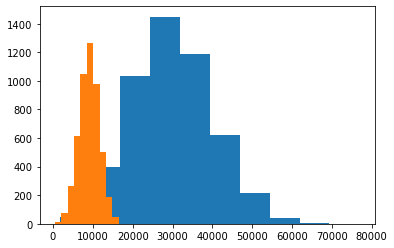

In [26]:
plt.hist(scf_data['AccountBalance'])
plt.hist(scf_data['scf_AccountBalance'])

(array([4934.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          66.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

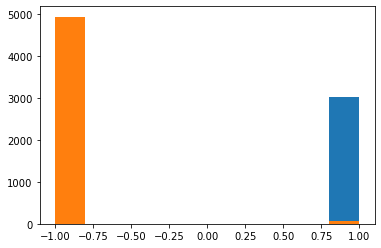

In [27]:
plt.hist(data['LoanApproval'])
plt.hist(np.sign(scf_data['AnnualSalary'] + beta_2*scf_data['scf_AccountBalance'] - 225000))

*Remarks:*

Above all, it seems that under causal sufficiency and under structural equations with linear functional form and an additive noise (ideally, Gaussian), we can perform Pearl's structural counterfactuals wihtout having to go crazy on the latent space... of course, here some very stringent assumptions take place: 
- we assume a noise additve model, 
- we assume a linear form, and 
- we assume $X_2$ to have Gaussian errors.

The above is only possible because we know the data generating process. We would then need to wonder what does this imply when some of these assumptions don't hold? At best, it's an assumption.

On $\alpha$, it roughly represents the level of variation of the noise. This is clearer under *white noise*. Similarly, now it is more clear to me what $U$ represents: the (most likely) individual error or unit characterization given the evidence for for each individual.

Here, we don't need a latent space nor anything fancy for generating the counterfactuals. This indeed is a simple model but it illustrates a new approach for discrimination discovery: *fairness given the difference*. I think we should focus on finishing this for situation testing under a simple approach and then push this further by exploring the consequences of non-normal noise or even non-linear forms.

*Remarks on Kusner (2017)*

I'd argue further that counterfactual fairness as a definition is not that useful, and, furthermore, the FairLearner they defined as nothing more than a 2-stage regression to construct a latent space that is perpendicular to the protected attributes. This is not useful nor for prediction nor for auditing. 

**How they cobstruct $U$ is nothing more than to find the missing confounder. That's not really an abduction step! Because you still have individual variability for each variable... you just want to be able to split the residual variance into what is known and what is not!**

In fact, my hunch is that the law school data has a low risk of confounding! That's why performance doesn't drop!

### Version 2: Causal Sufficiency; with $A$
With the DAG: $X_1->Y$, $X_1->X_2$, $X_2->Y$, $A -> X_1$, and $A -> X_2$.

In [28]:
# create systematic penalties around A
np.random.seed(2020) # to avoid identical draws as the Us
n = 5000

# Let A be Gender
p_men = 0.65
uA = random.choices(population=[0, 1], weights=[p_men, (1 - p_men)], k=n)
A = np.asanyarray(uA) # where A=1 represents female

bias_a1 = (-6500)*np.random.poisson(lam=10, size=n)
bias_a2 = (-500)*np.random.chisquare(df=4, size=n)

Notice that above we've assumed a single-sided bias: women can only be penalized in this scenario becuase they belong to the non-protected group. This means that we don't allow for situtaion in which men are also penalized or women benefited (forms of "reverse" discrimination).

In [29]:
#plt.hist(A)
#plt.hist(bias_a1)
#plt.hist(bias_a2)

In [30]:
# overall params
np.random.seed(2022)
n = 5000

# previous hyperparams
lambda_1 = 10000
lambda_2 = 2500
beta_1 = (3/10)
beta_2 = 5
#epsilon = 225000

u1 = lambda_1*np.random.poisson(lam=10, size=n)
u2 = lambda_2*np.random.normal(loc=0.0, scale=1.0, size=n)

# annual salary
n_x1 = u1 + A*bias_a1
# account balance
n_x2 = beta_1*n_x1 + u2 + A*bias_a2
# loan approval
n_y = np.sign(n_x1 + beta_2*n_x2 - 225000)

In [31]:
# store data for testing RStan 
n_d = {'LoanApproval': n_y, 
     'AnnualSalary': n_x1, 
     'AccountBalance': n_x2,
     'u1': u1,
     'u2': u2,
     'Gender': A}
n_data = pd.DataFrame(n_d)
n_data.head(10)

,LoanApproval,AnnualSalary,AccountBalance,u1,u2,Gender
0,-1.0,50000,14026.847358,50000,-973.152642,0
1,-1.0,68000,19497.832480,120000,940.097383,1
2,-1.0,90000,23564.129008,90000,-3435.870992,0
3,-1.0,-11000,-1451.336160,80000,3596.570524,1
4,1.0,210000,62294.221620,210000,-705.778380,0
5,-1.0,42000,7050.013667,120000,-3172.991276,1
6,-1.0,80000,19749.048087,80000,-4250.951913,0
7,1.0,140000,45716.973279,140000,3716.973279,0
8,-1.0,31000,8143.135197,70000,1540.642141,1
9,1.0,110000,30629.344885,110000,-2370.655115,0


(array([1577.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         117.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

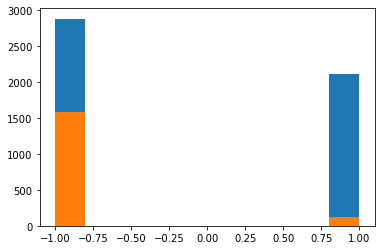

In [32]:
plt.hist(n_data['LoanApproval'])
plt.hist(n_data[n_data['Gender']==1]['LoanApproval']) # this is the factual!

In [45]:
# num. of women with approved loans / num. of women* 100
n_data[(n_data['Gender']==1) & (n_data['LoanApproval']==1)].shape[0] / n_data[n_data['Gender']==1].shape[0] * 100

6.90672963400236

In [46]:
# num. of men with approved loans / num. of men* 100
n_data[(n_data['Gender']==0) & (n_data['LoanApproval']==1)].shape[0] / n_data[n_data['Gender']==0].shape[0] * 100

60.526315789473685

In [47]:
# store in data folder
n_data.to_csv(data_path + '\\' + 'Karimi2020_v2.csv', sep='|', index=False)

In [ ]:
# prepare data for Salvatore's ST program:


For SCFs, we need to estimate the weighst (i.e., causal inference) for Account Balance and Annual Salary before we estimate $u_1$ and $u_2$; interven $A$; and precidt the counterfactual values for $x_1$ and $x_2$.

In [48]:
model_sal = LinearRegression(fit_intercept=True, normalize=False)
model_acc = LinearRegression(fit_intercept=True, normalize=False)

In [49]:
x_sal = np.array(n_data['Gender'].copy()).reshape((-1, 1))
print(x_sal.shape)
y_sal = np.array(n_data['AnnualSalary'].copy())
print(y_sal.shape)

x_acc = np.array(n_data[['AnnualSalary', 'Gender']].copy())#.reshape((-1, 1))
print(x_acc.shape)
y_acc = np.array(n_data['AccountBalance'].copy())
print(y_acc.shape)

(5000, 1)
(5000,)
(5000, 2)
(5000,)


In [50]:
model_sal.fit(x_sal, y_sal)
model_acc.fit(x_acc, y_acc)

LinearRegression()

In [51]:
model_sal.coef_

array([-64901.12981942])

In [52]:
model_sal.intercept_

100341.80278281916

In [53]:
model_acc.coef_

array([ 2.99338159e-01, -1.92234781e+03])

In [54]:
model_acc.intercept_

57.702090564391256

In [55]:
n_scf_data = n_data[['LoanApproval', 'AnnualSalary', 'AccountBalance', 'Gender', 'u1', 'u2']].copy()
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2
0,-1.0,50000,14026.847358,0,50000,-973.152642
1,-1.0,68000,19497.832480,1,120000,940.097383
2,-1.0,90000,23564.129008,0,90000,-3435.870992
3,-1.0,-11000,-1451.336160,1,80000,3596.570524
4,1.0,210000,62294.221620,0,210000,-705.778380


In [56]:
n_scf_data['hat_u1'] = round(n_scf_data['AnnualSalary'] - model_sal.predict(x_sal), 2)
n_scf_data['hat_u2'] = round(n_scf_data['AccountBalance'] - model_acc.predict(x_acc), 2)
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2,hat_u1,hat_u2
0,-1.0,50000,14026.847358,0,50000,-973.152642,-50341.80,-997.76
1,-1.0,68000,19497.832480,1,120000,940.097383,32559.33,1007.48
2,-1.0,90000,23564.129008,0,90000,-3435.870992,-10341.80,-3434.01
3,-1.0,-11000,-1451.336160,1,80000,3596.570524,-46440.67,3706.03
4,1.0,210000,62294.221620,0,210000,-705.778380,109658.20,-624.49


(array([1.000e+00, 3.200e+01, 2.170e+02, 1.392e+03, 1.679e+03, 1.165e+03,
        4.240e+02, 7.700e+01, 1.100e+01, 2.000e+00]),
 array([-144940.67 , -113480.783,  -82020.896,  -50561.009,  -19101.122,
          12358.765,   43818.652,   75278.539,  106738.426,  138198.313,
         169658.2  ]),
 <BarContainer object of 10 artists>)

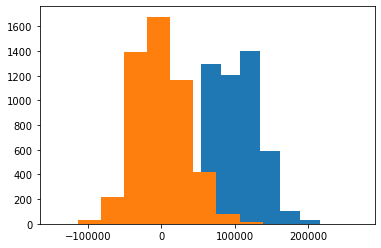

In [57]:
plt.hist(n_scf_data['u1'])
plt.hist(n_scf_data['hat_u1'])

(array([   2.,    3.,   24.,  196.,  592., 1280., 1564.,  971.,  309.,
          59.]),
 array([-13094.65 , -10989.248,  -8883.846,  -6778.444,  -4673.042,
         -2567.64 ,   -462.238,   1643.164,   3748.566,   5853.968,
          7959.37 ]),
 <BarContainer object of 10 artists>)

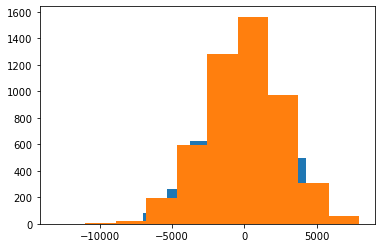

In [58]:
plt.hist(n_scf_data['u2'])
plt.hist(n_scf_data['hat_u2'])

In [59]:
# intervene on A
do_male = np.repeat(0, repeats=n_scf_data.shape[0]).reshape((-1, 1))

In [60]:
n_scf_data['scf_AnnualSalary'] = round(model_sal.predict(do_male) + n_scf_data['hat_u1'], 2)
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2,hat_u1,hat_u2,scf_AnnualSalary
0,-1.0,50000,14026.847358,0,50000,-973.152642,-50341.80,-997.76,50000.00
1,-1.0,68000,19497.832480,1,120000,940.097383,32559.33,1007.48,132901.13
2,-1.0,90000,23564.129008,0,90000,-3435.870992,-10341.80,-3434.01,90000.00
3,-1.0,-11000,-1451.336160,1,80000,3596.570524,-46440.67,3706.03,53901.13
4,1.0,210000,62294.221620,0,210000,-705.778380,109658.20,-624.49,210000.00


(array([1.000e+00, 3.200e+01, 2.170e+02, 1.392e+03, 1.679e+03, 1.165e+03,
        4.240e+02, 7.700e+01, 1.100e+01, 2.000e+00]),
 array([-44598.87 , -13138.983,  18320.904,  49780.791,  81240.678,
        112700.565, 144160.452, 175620.339, 207080.226, 238540.113,
        270000.   ]),
 <BarContainer object of 10 artists>)

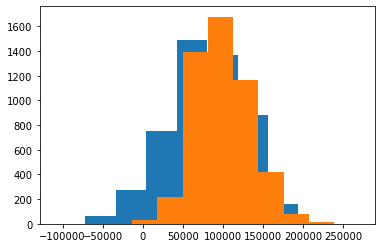

In [61]:
plt.hist(n_scf_data['AnnualSalary'])
plt.hist(n_scf_data['scf_AnnualSalary'])

In [62]:
temp_do = n_scf_data[['scf_AnnualSalary']].copy()
temp_do['Gender'] = do_male
temp_do.head(5)

,scf_AnnualSalary,Gender
0,50000.00,0
1,132901.13,0
2,90000.00,0
3,53901.13,0
4,210000.00,0


In [63]:
n_scf_data['scf_AccountBalance'] = round(model_acc.predict(temp_do) + n_scf_data['hat_u2'], 2)
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2,hat_u1,hat_u2,scf_AnnualSalary,scf_AccountBalance
0,-1.0,50000,14026.847358,0,50000,-973.152642,-50341.80,-997.76,50000.00,14026.85
1,-1.0,68000,19497.832480,1,120000,940.097383,32559.33,1007.48,132901.13,40847.56
2,-1.0,90000,23564.129008,0,90000,-3435.870992,-10341.80,-3434.01,90000.00,23564.13
3,-1.0,-11000,-1451.336160,1,80000,3596.570524,-46440.67,3706.03,53901.13,19898.40
4,1.0,210000,62294.221620,0,210000,-705.778380,109658.20,-624.49,210000.00,62294.23


(array([   9.,   72.,  517., 1333., 1595., 1041.,  356.,   65.,   10.,
           2.]),
 array([-9634.55 ,  -554.403,  8525.744, 17605.891, 26686.038, 35766.185,
        44846.332, 53926.479, 63006.626, 72086.773, 81166.92 ]),
 <BarContainer object of 10 artists>)

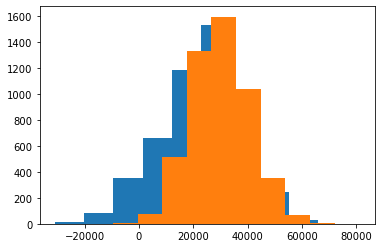

In [64]:
plt.hist(n_scf_data['AccountBalance'])
plt.hist(n_scf_data['scf_AccountBalance'])

In [65]:
n_scf_data['scf_LoanApproval'] = np.sign(n_scf_data['scf_AnnualSalary'] + beta_2*n_scf_data['scf_AccountBalance'] - 225000)
n_scf_data.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender,u1,u2,hat_u1,hat_u2,scf_AnnualSalary,scf_AccountBalance,scf_LoanApproval
0,-1.0,50000,14026.847358,0,50000,-973.152642,-50341.80,-997.76,50000.00,14026.85,-1.0
1,-1.0,68000,19497.832480,1,120000,940.097383,32559.33,1007.48,132901.13,40847.56,1.0
2,-1.0,90000,23564.129008,0,90000,-3435.870992,-10341.80,-3434.01,90000.00,23564.13,-1.0
3,-1.0,-11000,-1451.336160,1,80000,3596.570524,-46440.67,3706.03,53901.13,19898.40,-1.0
4,1.0,210000,62294.221620,0,210000,-705.778380,109658.20,-624.49,210000.00,62294.23,1.0


(array([1991.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3009.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

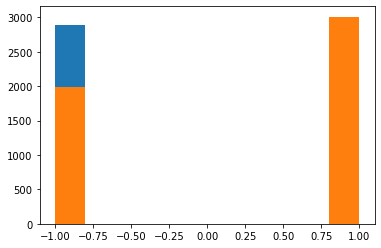

In [66]:
plt.hist(n_scf_data['LoanApproval'])
plt.hist(n_scf_data['scf_LoanApproval'])

(array([ 686.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1008.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

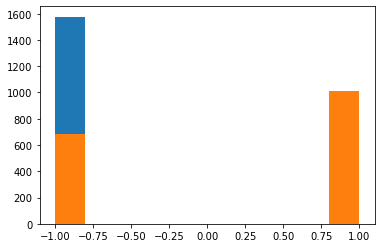

In [67]:
plt.hist(n_scf_data[n_scf_data['Gender']==1]['LoanApproval'])
plt.hist(n_scf_data[n_scf_data['Gender']==1]['scf_LoanApproval'])

In [ ]:
# # consider individual i: what is the counterfactual of y_i?
# # here, in ST, want the STRUCTURAL COUNTERFACTUAL x_scf, not too interested in y_scf
# # because want to match x_scf with those that don't share the protected attribute memebership of i
# i = 3
# data.loc[i, ]

# # Step 1: Abduction
# # Get U's given the evidence X's [assuming causal sufficiency and, ofc, a known causal graph]

# # u1 given x1: from Fig.1, x1 = u1 and thus u1 = x1
# u1_i = data.loc[i, 'X1']
# print(u1_i)

# # u2 given x2: from Fig.1, x2 = (3/10)*x1 + u2 and thus u2 = x2 - (3/10)*x1
# u2_i = data.loc[i, 'X2'] - (3/10)*data.loc[i, 'X1']
# print(u2_i)

# # Step 2: Action
# # Given the SCM, intervene it accordingly using the do-operator 
# delta = 5000

# # Org SCM M:
# # x1 = u1             [salary]
# # x2 = (3/10)*x1 + u2 [balance]

# # do(X1 := X1 + delta), then M':
# # X1' := X1 + delta
# # X2 = (3/10)*X1' + U2

# # Step 3: Prediction (notice at at i-level)
# # Apply the chagnes on M' and get the scf tuple 

# x1_i_scf = data.loc[i, 'X1'] + delta
# print(x1_i_scf)

# x2_i_scf = (3/10)*x1_i_scf + u2_i
# print(x2_i_scf)

# print(data.loc[i, 'Y'])
# # vs
# print(np.sign(x1_i_scf + 5*x2_i_scf - 225000))